In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
## Load all the necessary packages

%matplotlib inline

import matplotlib.pyplot as plt
import skimage.transform
from skimage import data, io, filters
import numpy as np
from numpy import array
from skimage.transform import rescale, resize
from skimage.transform import resize
import os
import PIL
import pandas as pd
import imageio


from matplotlib.pyplot import imread
import cv2
import h5py

In [3]:
## Load Directory Paths

def load_path(path):
    directories = []
    if os.path.isdir(path):
        print('directory path: ', path)
        directories.append(path)
    for elem in os.listdir(path): #check for nested dir within parent dir
        if os.path.isdir(os.path.join(path,elem)):
            print('inside nested dir')
            directories = directories + load_path(os.path.join(path,elem))
            directories.append(os.path.join(path,elem))
    print('directories: ', directories)
    return directories

In [4]:
## Load HR and SR Images from directory

def load_data_from_dirs(dirs, ext):
    files = []
    file_names = []
    count = 0
    
    for d in dirs:
        for f in os.listdir(d):
            if f.endswith(ext):
                image = cv2.imread(os.path.join(d,f))
                files.append(image)
                file_names.append(os.path.join(d,f))
                count = count + 1
    
    print('list of files: ',len(files))
    print('list of files path: ', len(file_names), 'file path: ', file_names[0])
    print('Files Read: ',count)
    
    return files  

In [5]:
## Load .mat Images from directory

def load_matdata_from_dirs(dirs, ext):
    files = []
    file_names = []
    count = 0
    
    for d in dirs:
        for f in os.listdir(d):
            if f.endswith(ext):
                image = h5py.File(os.path.join(d,f), 'r')
                files.append(image)
                file_names.append(os.path.join(d,f))
                count = count + 1
    
    print('list of files: ',len(files), 'file: ', files[0])
    print('list of files path: ', len(file_names), 'file path: ', file_names[0])
    print('Files Read: ',count)
    
    return files  

In [6]:
## Load SR and HR Images

def load_data(directory, ext):
    files = load_data_from_dirs(load_path(directory), ext)
    return files

In [7]:
## Load .mat data files

def load_matdata(directory, ext):
    files = load_matdata_from_dirs(load_path(directory), ext)
    return files

In [8]:
## Load .mat files to get tumor mask

matfiles = load_matdata("../input/mat-images/BrainTumorData/", ".mat")

directory path:  ../input/mat-images/BrainTumorData/
directories:  ['../input/mat-images/BrainTumorData/']
list of files:  3064 file:  <HDF5 file "2912.mat" (mode r)>
list of files path:  3064 file path:  ../input/mat-images/BrainTumorData/2912.mat
Files Read:  3064


In [9]:
## get mask for the images

images_h5 = matfiles[:1000]
tumor_mask = np.array([np.array(img_h5['cjdata']['tumorMask'][()].astype(np.uint32), dtype='object') for img_h5 in images_h5], dtype='object')

In [10]:
# checking for invalid shape images

for idx, img in enumerate(tumor_mask):
    if img.shape != (512,512):
        print(idx, img.shape)

154 (256, 256)
479 (256, 256)
510 (256, 256)
806 (256, 256)
847 (256, 256)
852 (256, 256)


In [11]:
new_tumor_mask = []
for img in tumor_mask:
    if img.shape == (512,512):
        new_tumor_mask.append(img)

In [12]:
## get mask for sr images

img_mask = []
for i in range(600,800):
    img_mask.append(new_tumor_mask[i])

In [13]:
## Load HR Images from the directory

hr_brain_files = load_data("../input/escpn-srhr-images/HR_Images/", ".jpeg")

directory path:  ../input/escpn-srhr-images/HR_Images/
directories:  ['../input/escpn-srhr-images/HR_Images/']
list of files:  200
list of files path:  200 file path:  ../input/escpn-srhr-images/HR_Images/HighRes_170.jpeg
Files Read:  200


In [14]:
## Convert each jpeg image to UMat format to apply polygon curve approximation in opencv2

hr_brain_images = []
for i in range(len(hr_brain_files)):
    hr_brain_images.append(cv2.cvtColor(cv2.UMat(hr_brain_files[i]), cv2.COLOR_RGB2GRAY))

In [15]:
## Function to display UMat images

def displayImages(img_arr):    
    width=8
    height=8
    rows = 3
    cols = 4
    axes=[]

    fig=plt.figure(figsize=(10,10))

    for i in range(rows * cols):
        axes.append( fig.add_subplot(rows, cols, i+1) )
        subplot_title=("Image: "+str(i+1))
        axes[-1].set_title(subplot_title)  
        plt.imshow(img_arr[i].get().astype('f'), cmap='gray')
        plt.axis('off')
    fig.tight_layout()    
    plt.show()

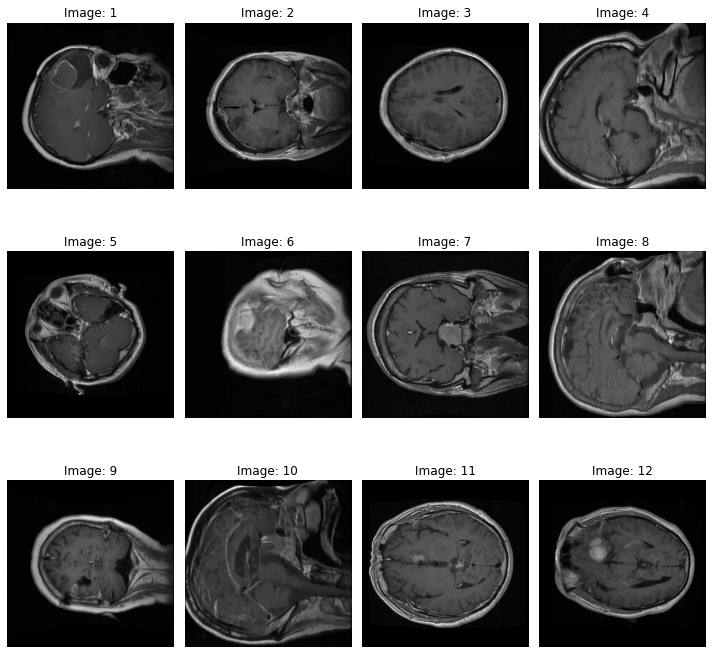

In [16]:
## Visualize few Brain images extracted using binary mask

displayImages(hr_brain_images)

In [17]:
hr_masked_images = [img.get()*mask for img, mask in zip(hr_brain_images, img_mask)]

In [18]:
hr_mask_removed = []
for mask_img, brain_img in zip(hr_masked_images, hr_brain_images):
    hr_mask_removed.append(brain_img.get() - mask_img)

In [19]:
def displayFinalResults(brain_images, tumor_images, final_images, dim=(1, 3), figsize=(15, 5)):
    rows = 3
    cols = 4
    
    for i in range(rows * cols):
        
        fig, axes = plt.subplots(ncols=3, figsize=(10, 3))
        ax = axes.ravel()
        ax[0] = plt.subplot(1, 3, 1)
        ax[1] = plt.subplot(1, 3, 2)
        ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

        ax[0].imshow(brain_images[i].get(), cmap=plt.cm.gray)
        ax[0].set_title('Brain Image after Applying Thresholding')
        ax[0].axis('off')

        ax[1].imshow(np.array(tumor_images[i], dtype='float').squeeze(), cmap=plt.cm.gray)
        ax[1].set_title('Tumor Mask')
        ax[1].axis('off')

        ax[2].imshow(np.array(final_images[i], dtype='float'), cmap=plt.cm.gray)
        ax[2].set_title('Final Image After Removing Mask')
        ax[2].axis('off')

        fig.tight_layout() 
        plt.show()

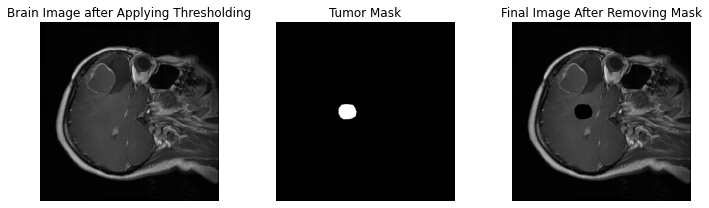

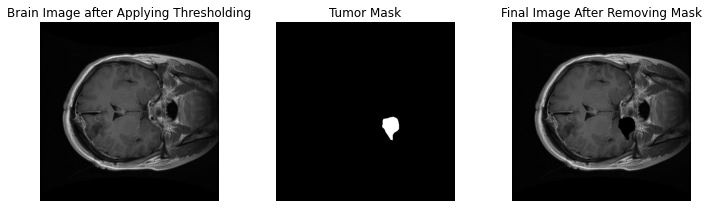

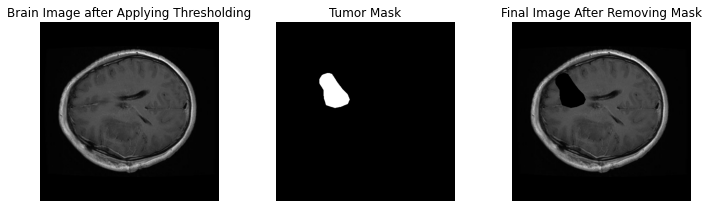

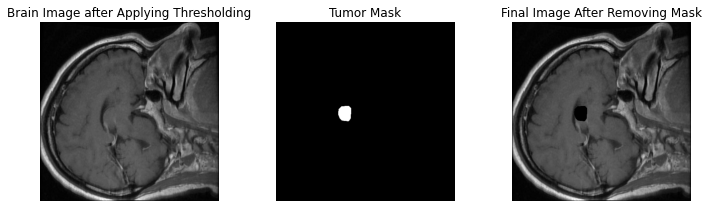

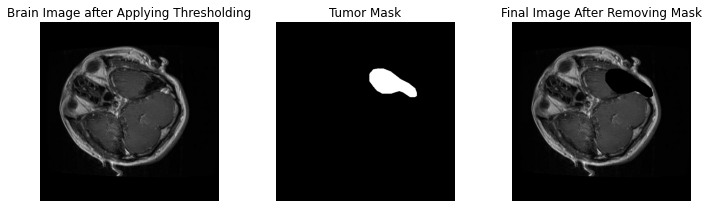

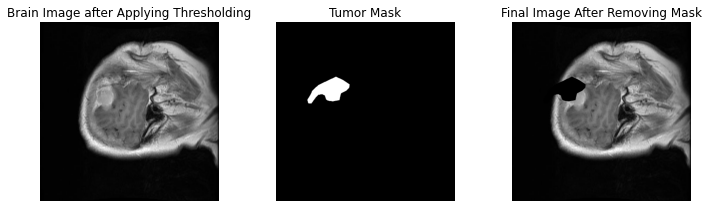

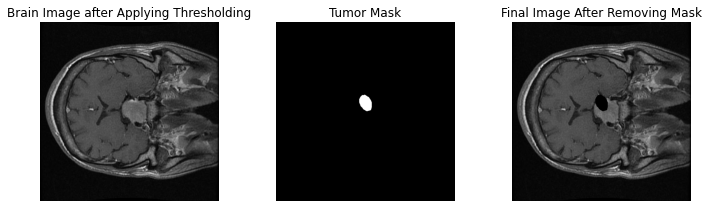

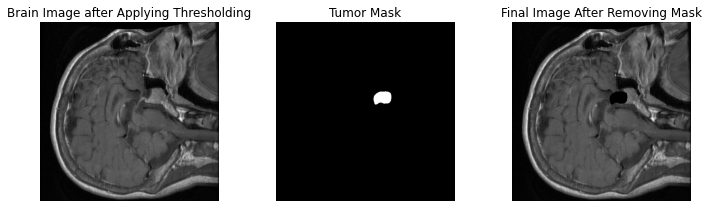

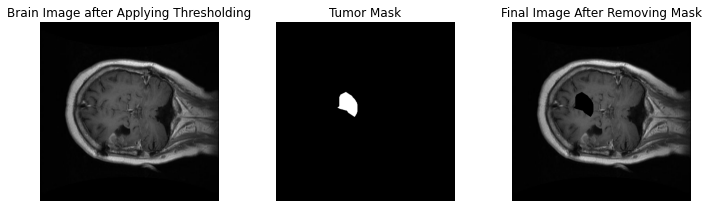

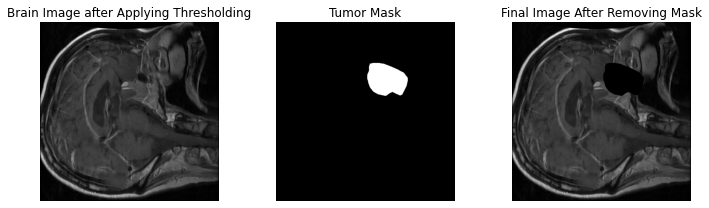

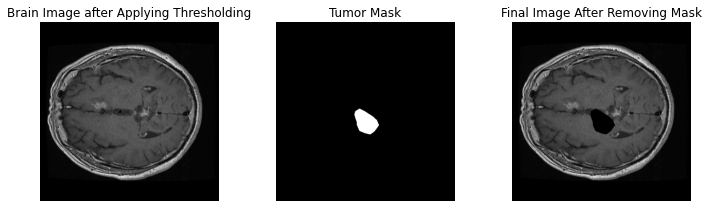

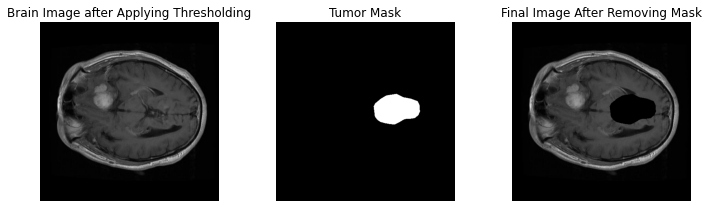

In [20]:
displayFinalResults(hr_brain_images, img_mask, hr_mask_removed)

In [21]:
## Load SR Images from the directory

sr_brain_files = load_data("../input/escpn-srhr-images/SR_Images/", ".jpeg")

directory path:  ../input/escpn-srhr-images/SR_Images/
directories:  ['../input/escpn-srhr-images/SR_Images/']
list of files:  200
list of files path:  200 file path:  ../input/escpn-srhr-images/SR_Images/SR_103.jpeg
Files Read:  200


In [22]:
## Convert each image to UMat in order to apply 

sr_brain_images = []
for i in range(len(hr_brain_files)):
    sr_brain_images.append(cv2.cvtColor(cv2.UMat(hr_brain_files[i]), cv2.COLOR_RGB2GRAY))

In [23]:
sr_masked_images = [img.get()*mask for img, mask in zip(sr_brain_images, img_mask)]

In [24]:
sr_mask_removed = []
for mask_img, brain_img in zip(sr_masked_images, sr_brain_images):
    sr_mask_removed.append(brain_img.get() - mask_img)

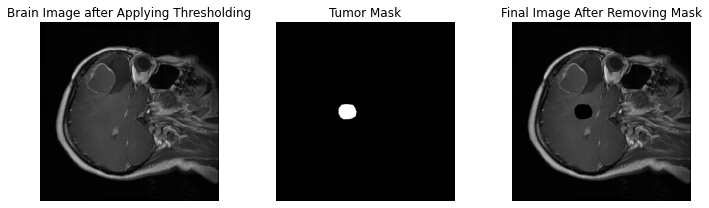

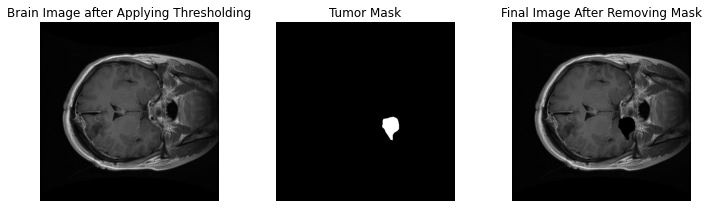

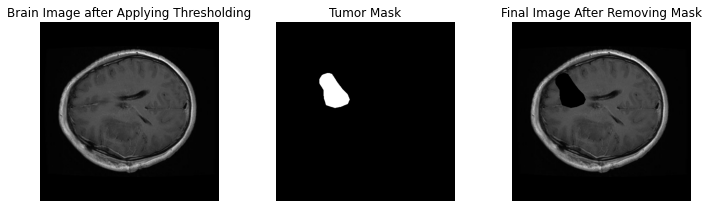

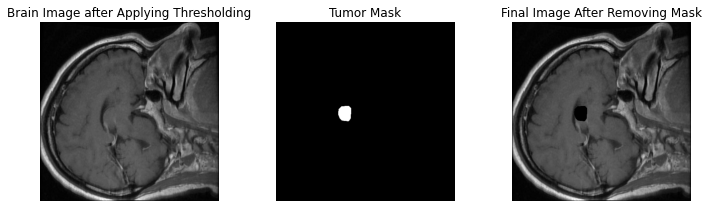

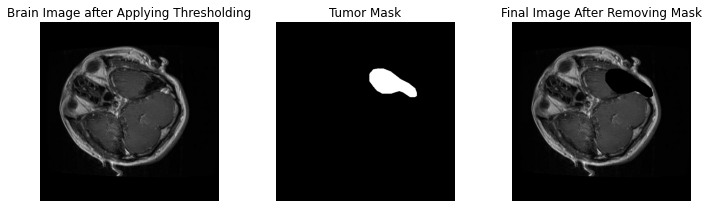

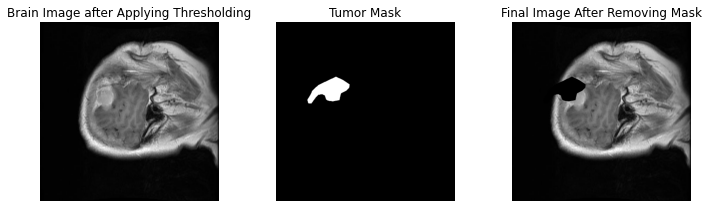

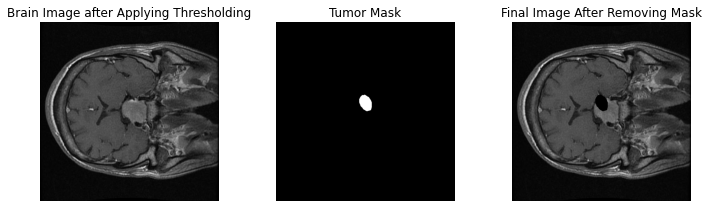

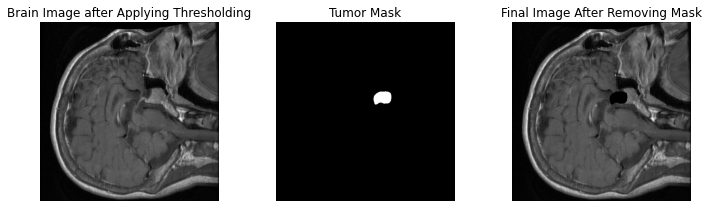

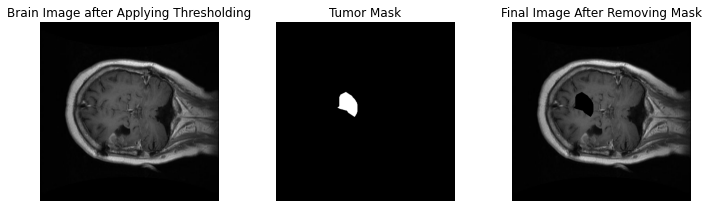

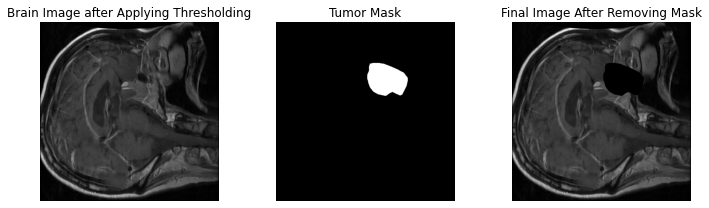

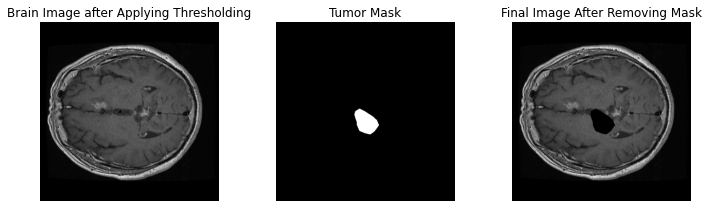

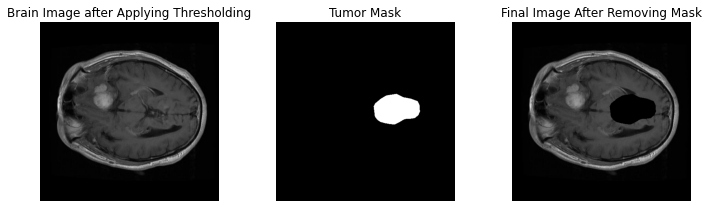

In [25]:
displayFinalResults(sr_brain_images, img_mask, sr_mask_removed)

## Defining Constants C1 and C2 and C3

### C1 = (K1,L)
### C2 = (K2,L)
### C3 = C2/2

## L is the dynamic range for pixel values [How to decide Value of L?](https://scikit-image.org/docs/dev/user_guide/data_types.html)

**Here K1 and K2 are constant values very very close to 0** 

In [26]:
C1 = (0.01 * 65535) ** 2 
C2 = (0.03 * 65535) ** 2
C3 = C2/2

In [27]:
def luminance(img1, img2):
    mu1 = img1.mean()
    mu2 = img2.mean()
    mu1_sqr = mu1 ** 2
    mu2_sqr = mu2 ** 2
    L = (2*mu1*mu2 + C1) / (2*(mu1_sqr + mu2_sqr) + C1)
    return L

In [28]:
def contrast(img1, img2):
    sigma1 = img1.std()
    sigma2 = img2.std()
    sigma1_sqr = sigma1 ** 2
    sigma2_sqr = sigma2 ** 2
    C = (2*sigma1*sigma2 + C2) / (2*(sigma1_sqr + sigma2_sqr) + C2)
    return C

In [29]:
def structure(img1, img2):
    C3 = C2/2
    sigma1 = img1.std()
    sigma2 = img2.std()
    sigma12 = np.cov(img1, img2)[0,1]
    S = (sigma12 + C3) / (2*sigma1*sigma2 + C3) 
    return S

In [30]:
def compute_ssim(sr_img, hr_img):
    
    sr_img = sr_img.astype(np.uint16)
    hr_img = hr_img.astype(np.uint16)
    
    img1 = np.array(list(filter(lambda pixel : pixel !=0, sr_img.flatten())))
    img2 = np.array(list(filter(lambda pixel : pixel !=0, hr_img.flatten())))
    
    ## Computing Luminance Comparison Function
    
    L = luminance(img1, img2)
    
    ## Computing Contrast Comparison Function
    
    C = contrast(img1, img2)
    
    ## Computing Structure Comparison Function
    
    S = structure(img1, img2)
    
    ## defining alpha, beta, gamma
    
    alpha, beta, gamma = 1, 1, 1

    ssim = (L ** alpha) * (C ** beta) * (S ** gamma)
    
    return ssim

In [31]:
## Compute SSIM for single image

compute_ssim(sr_mask_removed[22],hr_mask_removed[22])

0.9840714216732857

In [32]:
ssim_arr = []
for sr_img, hr_img in zip(sr_mask_removed,hr_mask_removed):
    ssim_arr.append(compute_ssim(sr_img, hr_img))
    
## Display Results for starting 10 images

print(ssim_arr[:10])

[0.9918605406208175, 0.9898840710782558, 0.9891807039304708, 0.9795074903844139, 0.9919373795391331, 0.9823550091213183, 0.9882826763831886, 0.9800601992413335, 0.9897170185513382, 0.9893390359491486]


## Universal Quality Index (UQI)

### It is special case of SSIM when C1=0 and C2=0

**NOTE: It produces unstable results when either (mu1_srq + mu2_srq) or (sigma1_sqr + sigma2_sqr) is close to 0**

In [33]:
C1 = 0 
C2 = 0
C3 = C2/2

In [34]:
def compute_uqi(sr_img, hr_img):
    
    
    sr_img = sr_img.astype(np.uint16)
    hr_img = hr_img.astype(np.uint16)
    
    img1 = np.array(list(filter(lambda pixel : pixel !=0, sr_img.flatten())))
    img2 = np.array(list(filter(lambda pixel : pixel !=0, hr_img.flatten())))
    
    ## Computing Luminance Comparison Function
    
    L = luminance(img1, img2)
    
    ## Computing Contrast Comparison Function
    
    C = contrast(img1, img2)
    
    ## Computing Structure Comparison Function
    
    S = structure(img1, img2)
    
    ## defining alpha, beta, gamma
    
    alpha, beta, gamma = 1, 1, 1

    uqi = (L ** alpha) * (C ** beta) * (S ** gamma)
    
    return uqi

In [35]:
## Compute UQI for single image

compute_uqi(sr_mask_removed[22],sr_mask_removed[22])

0.12500049094693833

In [36]:
uqi_arr = []
for sr_img, hr_img in zip(sr_mask_removed,hr_mask_removed):
    uqi_arr.append(compute_uqi(sr_img, hr_img))

## Display Results for starting 10 images

print(uqi_arr[:10])

[0.12500049815284914, 0.12500061111545674, 0.125000709316446, 0.12500048926551455, 0.1250007190313209, 0.12500050146025224, 0.12500048596154303, 0.12500048971980196, 0.12500061181837313, 0.12500050461419213]


In [37]:
def displayResults(img_arr1, img_arr2,ssim_arr, metric, dim=(1, 3), figsize=(15, 5)):    
    width=8
    height=8
    rows = 5
    cols = 5
    axes=[]

    fig=plt.figure(figsize=(10,10))

    for i in range(rows * cols):
        plt.figure(figsize=figsize)

        plt.subplot(dim[0], dim[1], 1)
        plt.imshow(np.array(img_arr1[i], dtype='float').squeeze(), interpolation='nearest', cmap='gray')
        plt.title(f"Super Resolution Image Tumor {i+1}")
        plt.axis('off')

        plt.subplot(dim[0], dim[1], 2)
        plt.imshow(np.array(img_arr2[i], dtype='float').squeeze(), interpolation='nearest', cmap='gray')
        plt.title(f"Origial Image Tumor {i+1}")
        plt.axis('off')
        
        plt.subplot(dim[0], dim[1], 3)
        plt.text(0.5, 0.5,f"{metric} {ssim_arr[i]}")
        plt.axis('off')
        
    fig.tight_layout()    
    plt.show()

## Display SSIM Results for starting 10 Images

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


<Figure size 720x720 with 0 Axes>

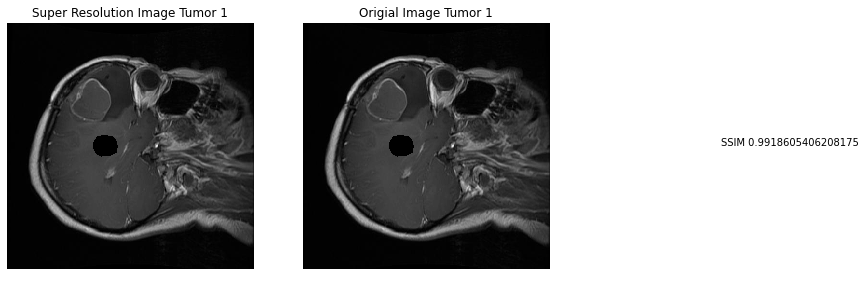

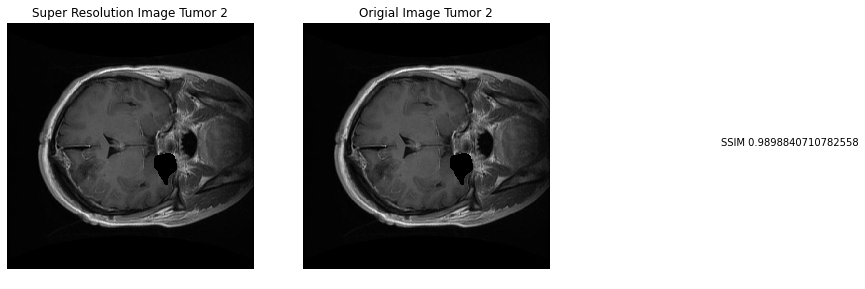

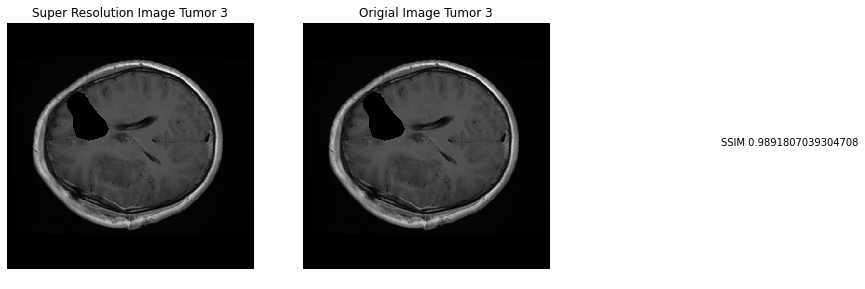

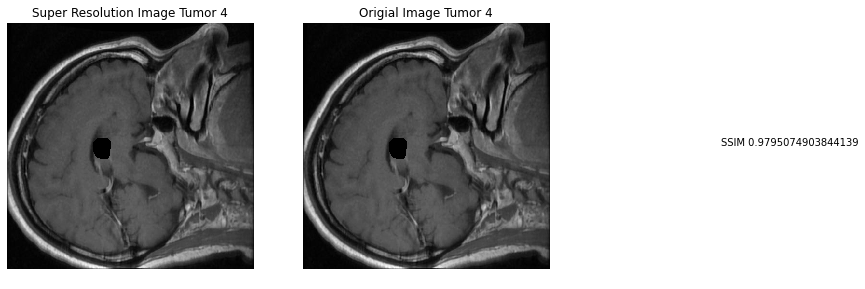

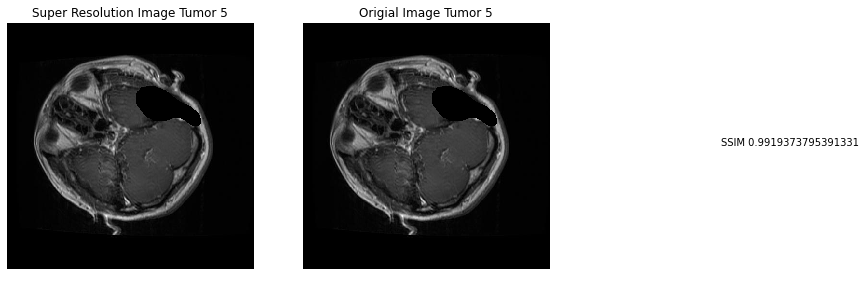

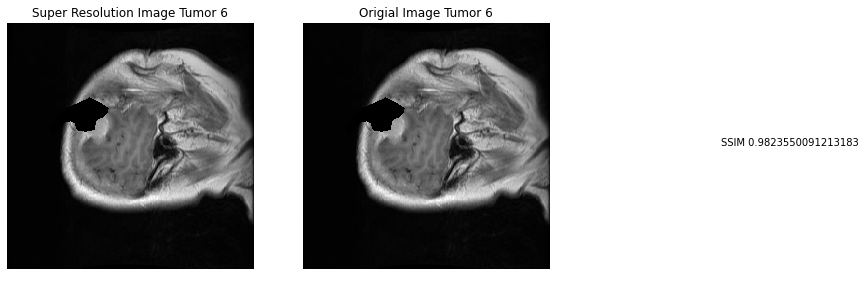

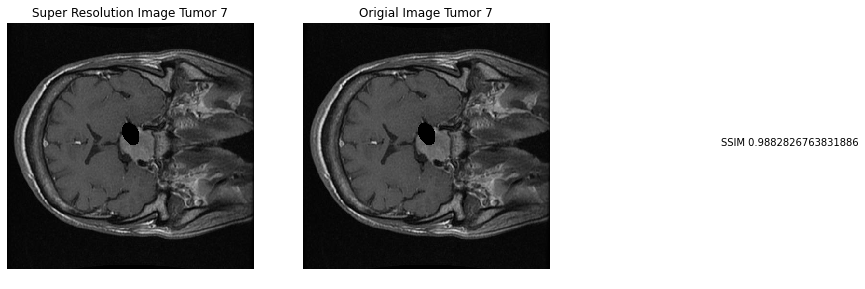

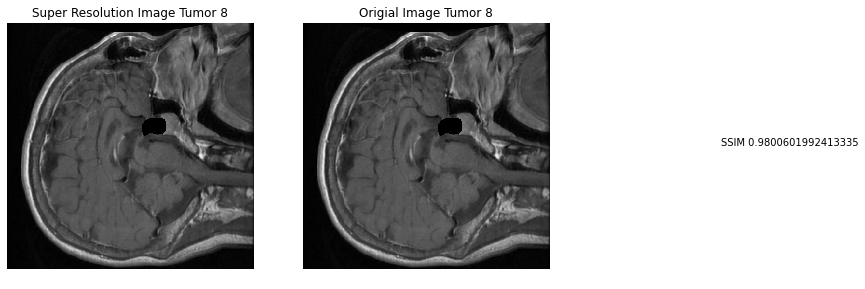

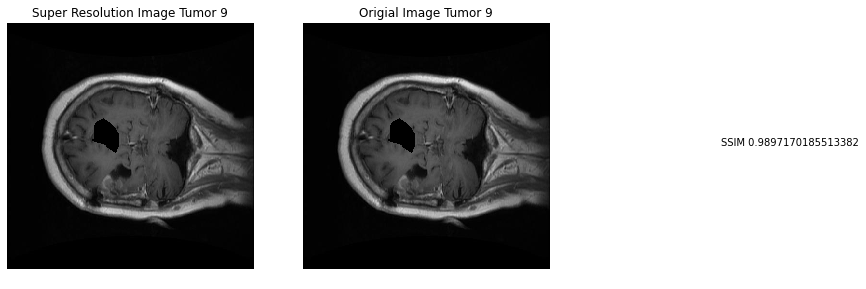

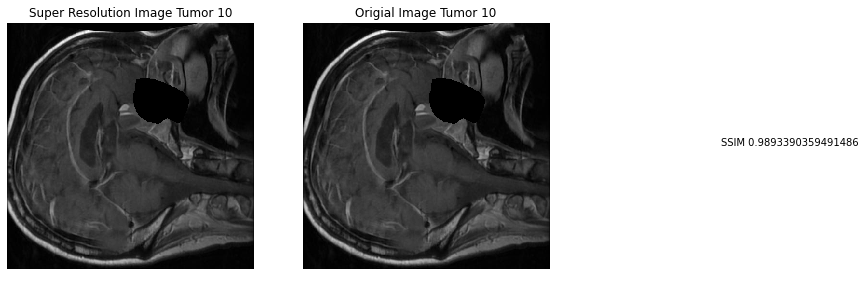

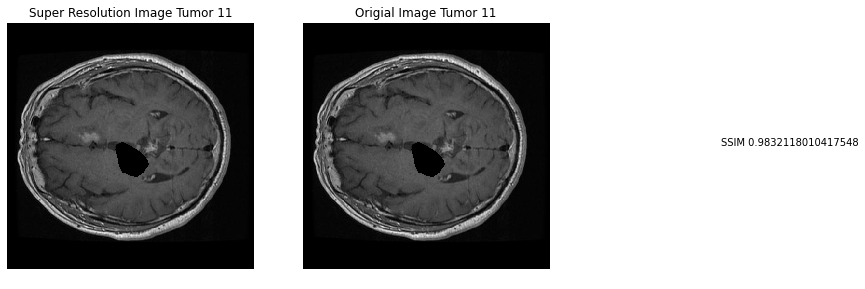

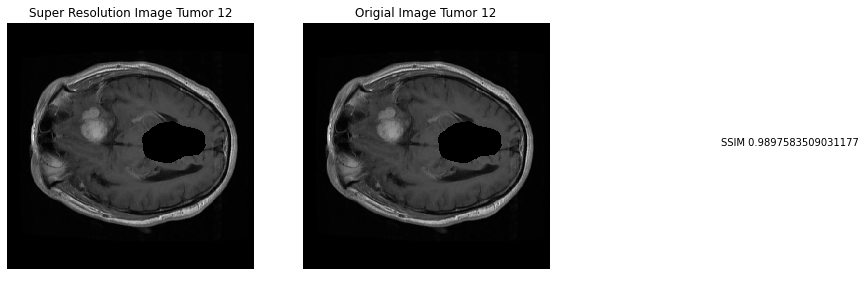

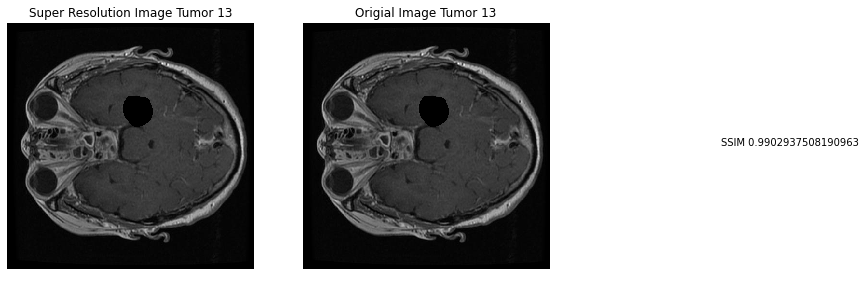

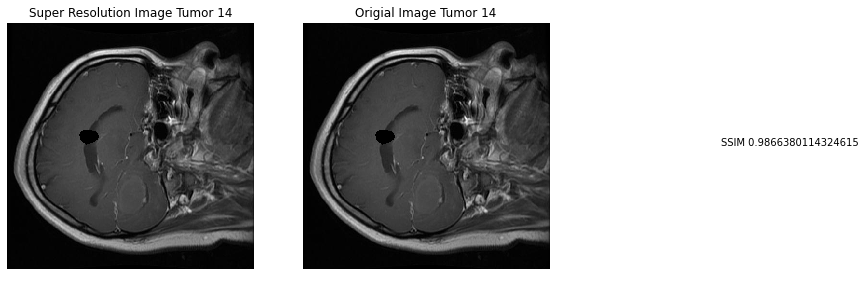

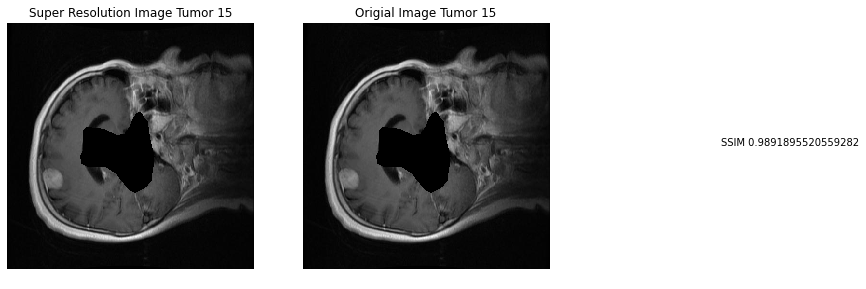

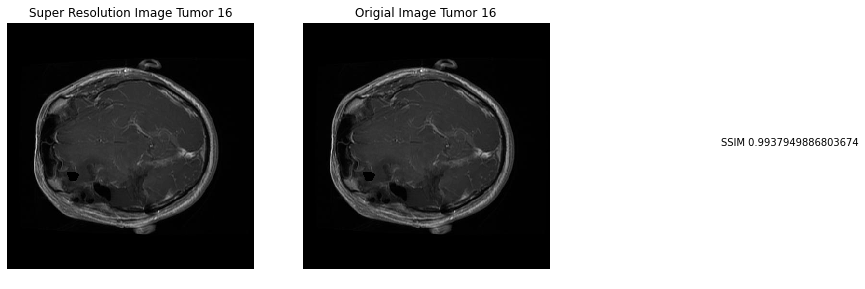

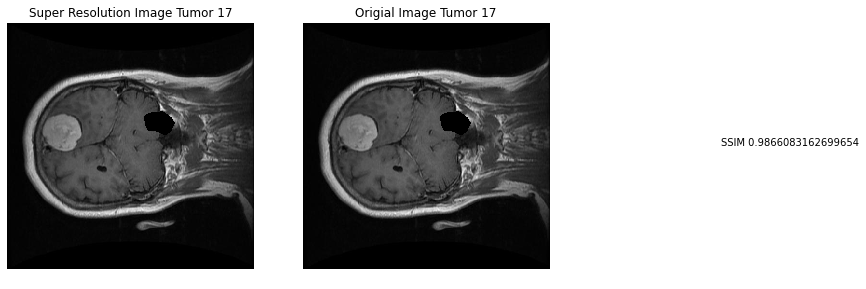

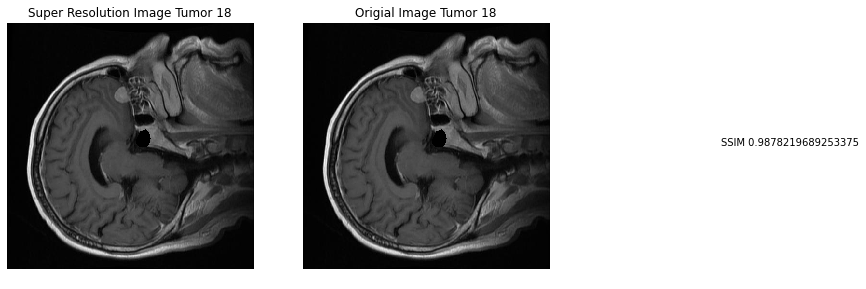

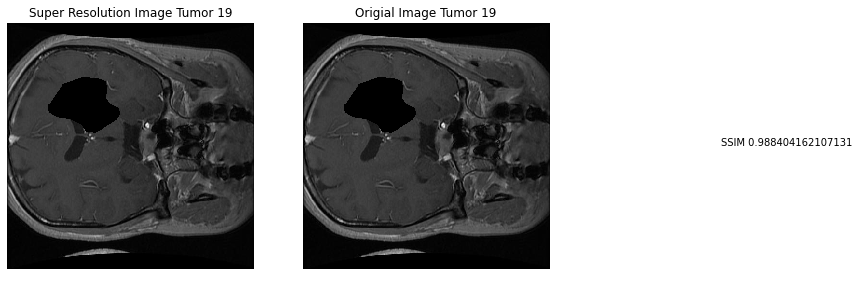

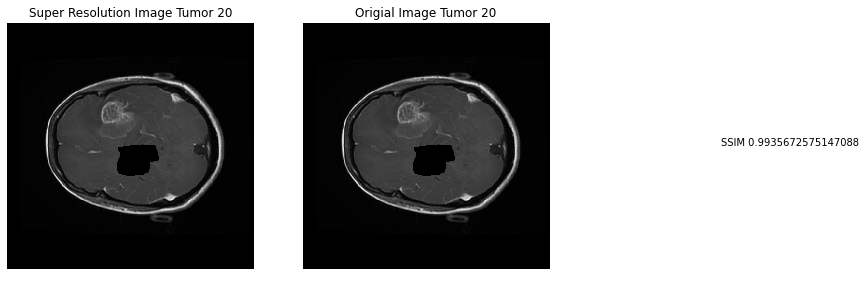

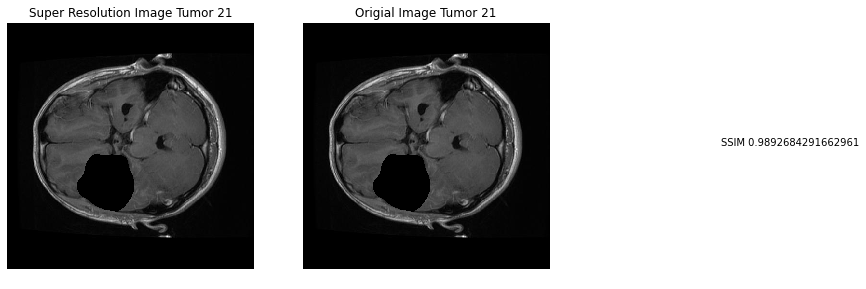

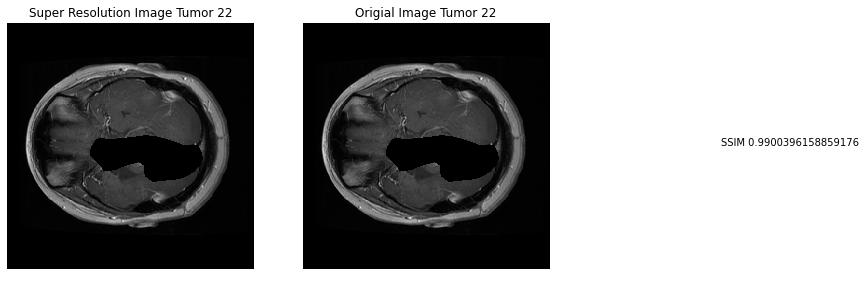

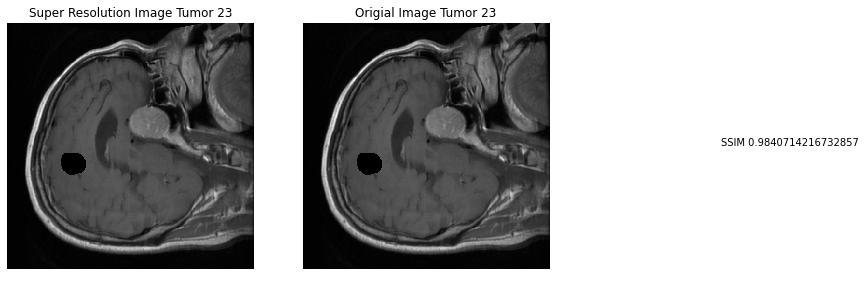

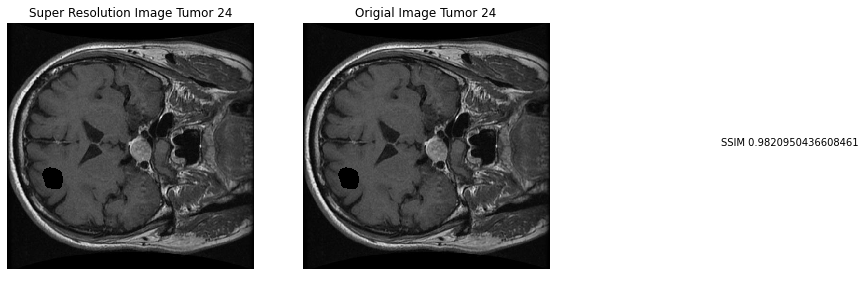

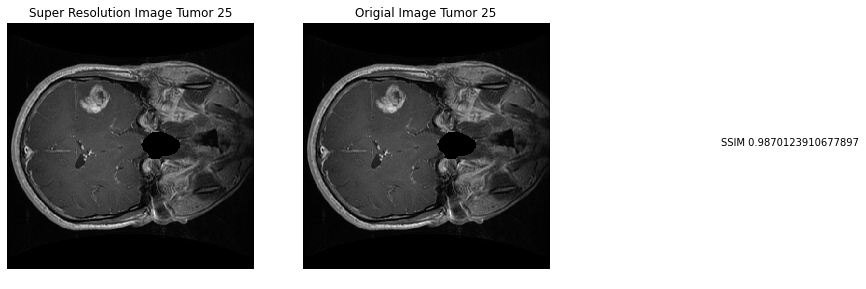

In [38]:
displayResults(sr_mask_removed, hr_mask_removed, ssim_arr, "SSIM")

## Display UQI (Universal Quality Index) Results for starting 10 Images

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


<Figure size 720x720 with 0 Axes>

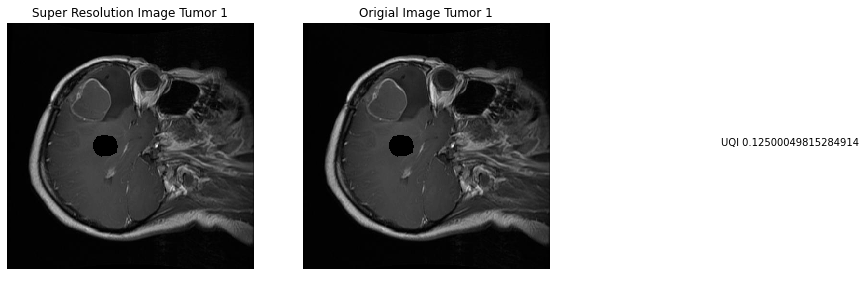

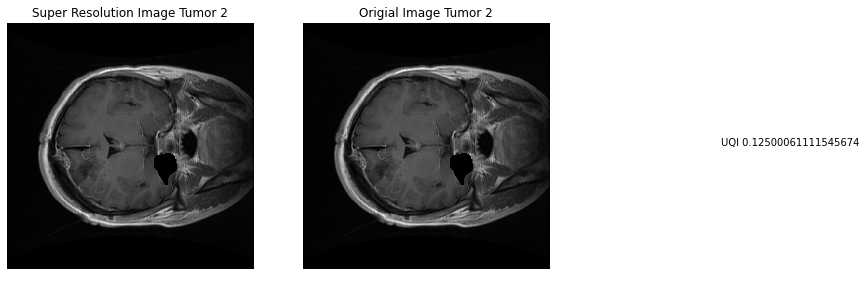

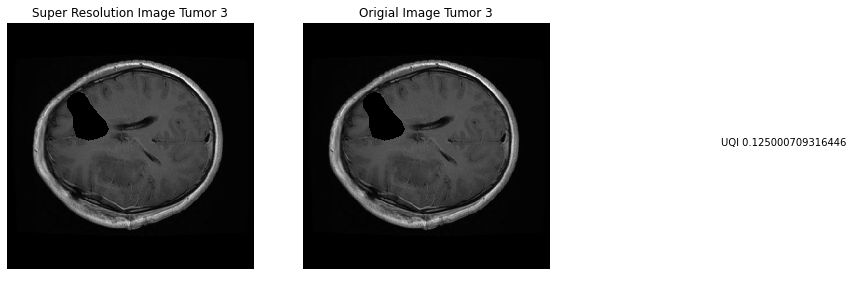

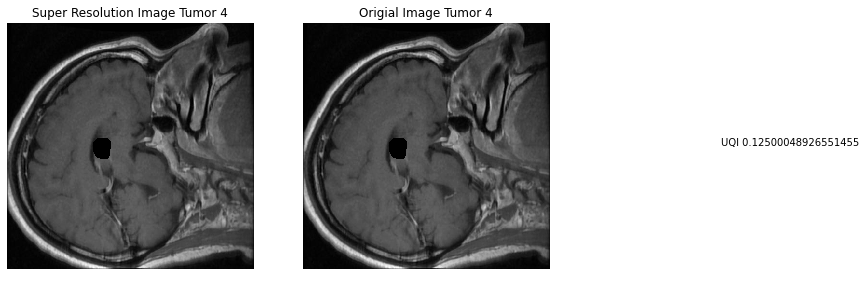

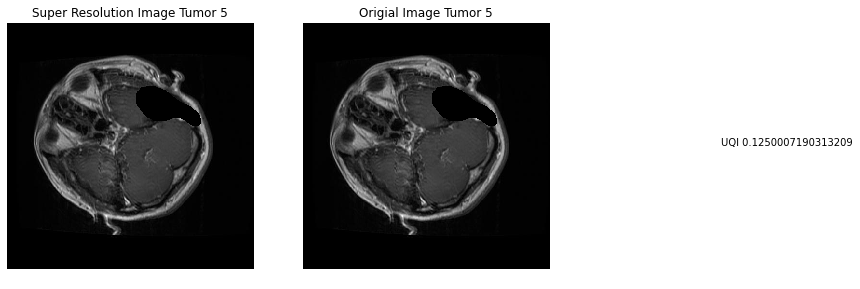

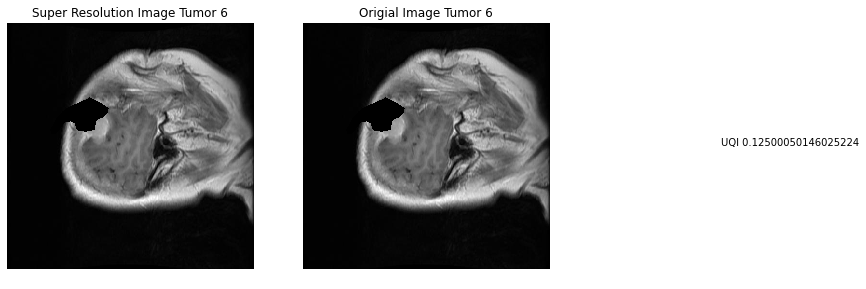

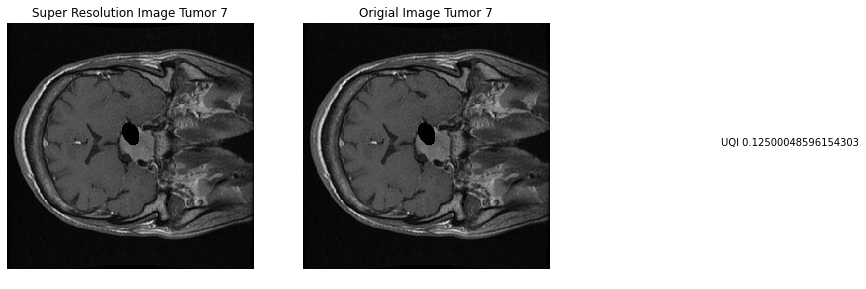

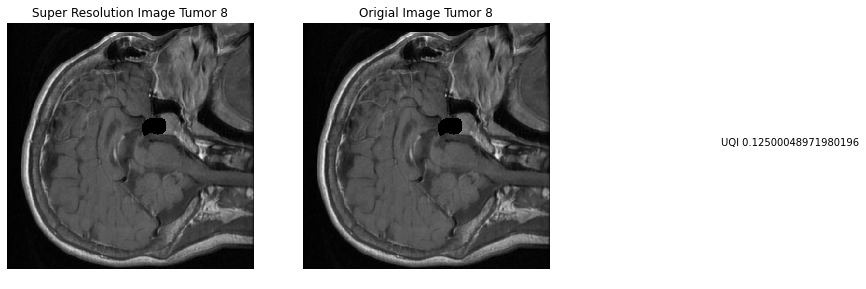

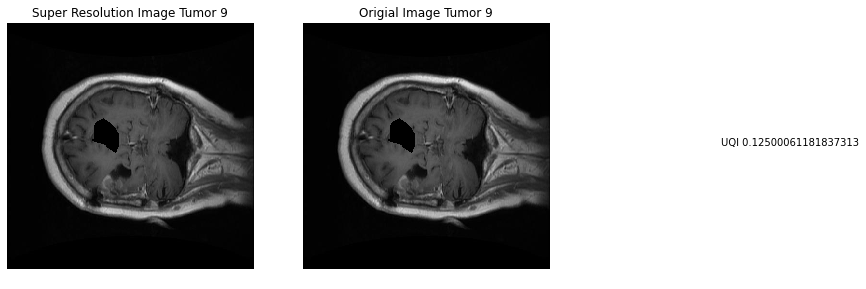

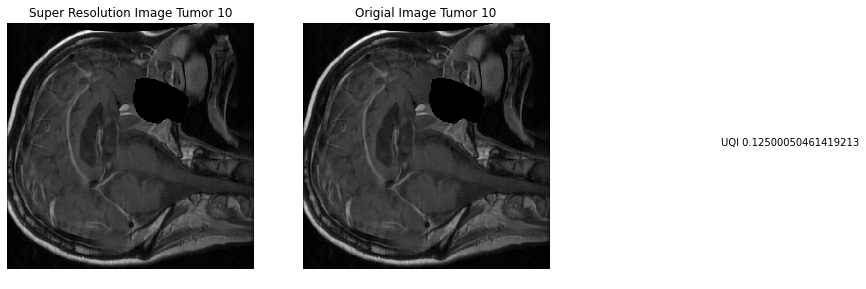

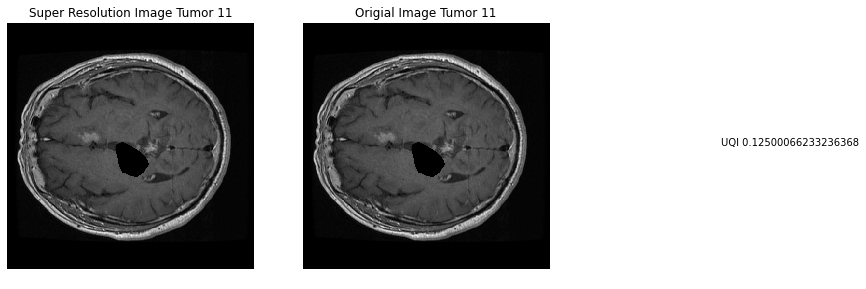

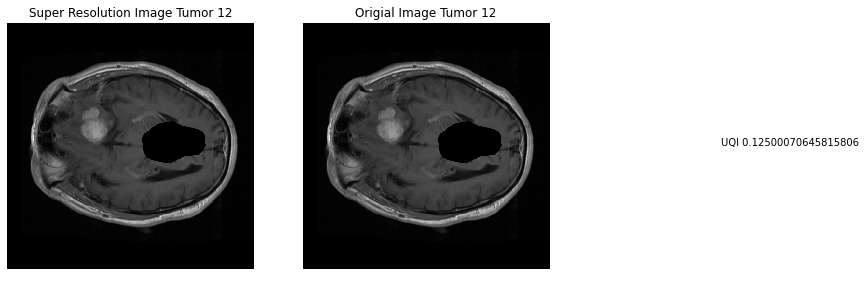

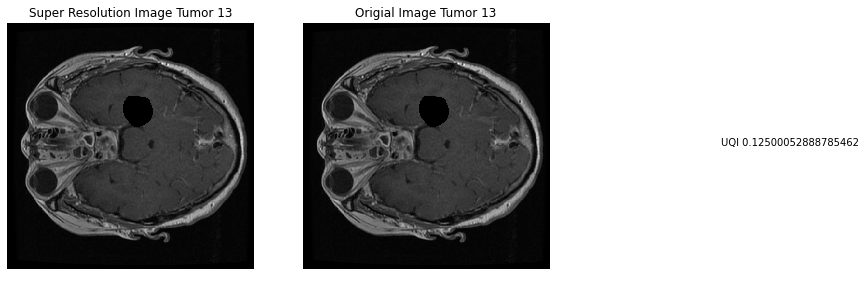

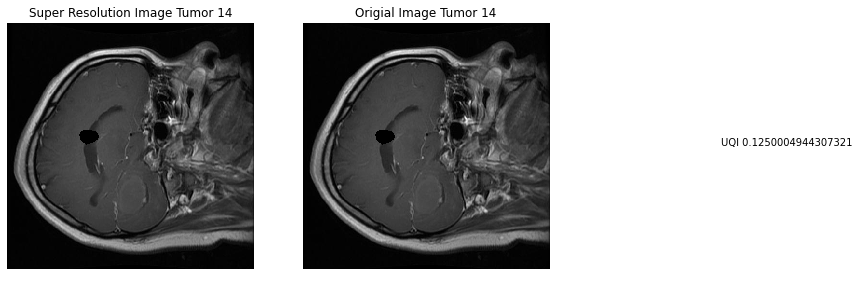

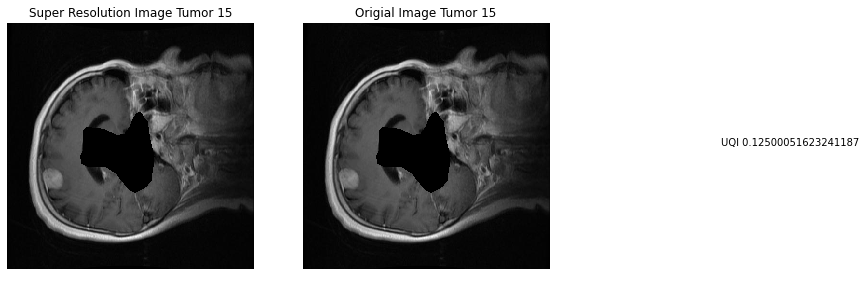

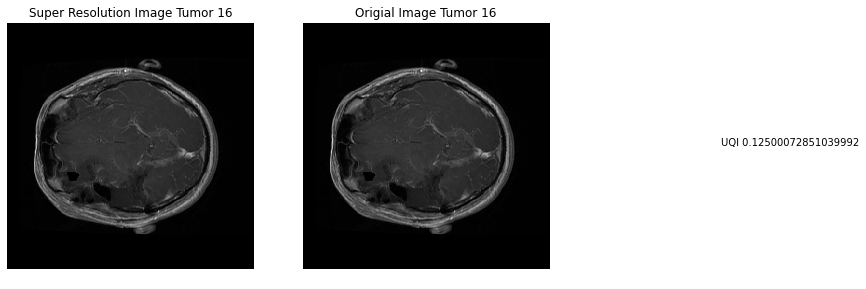

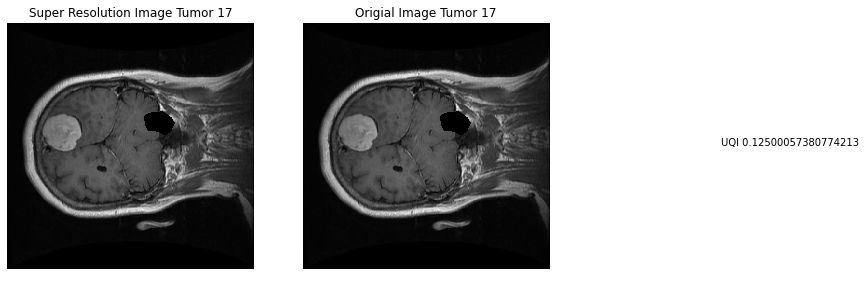

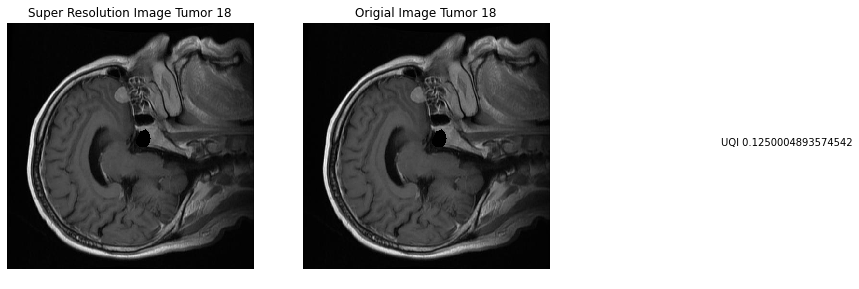

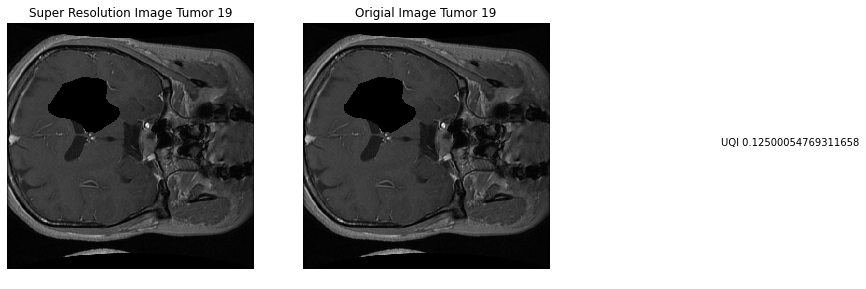

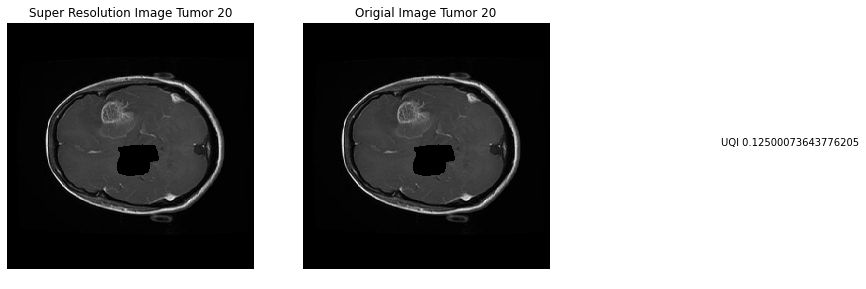

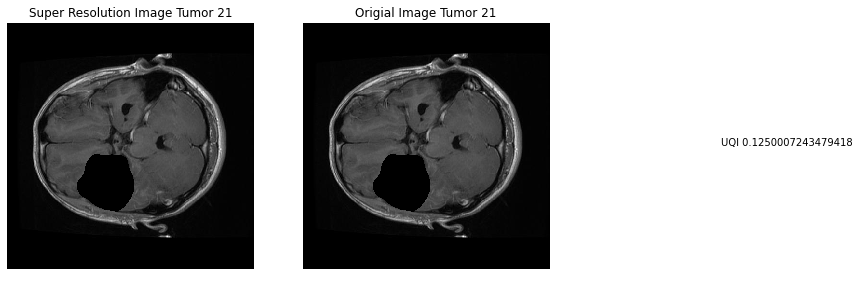

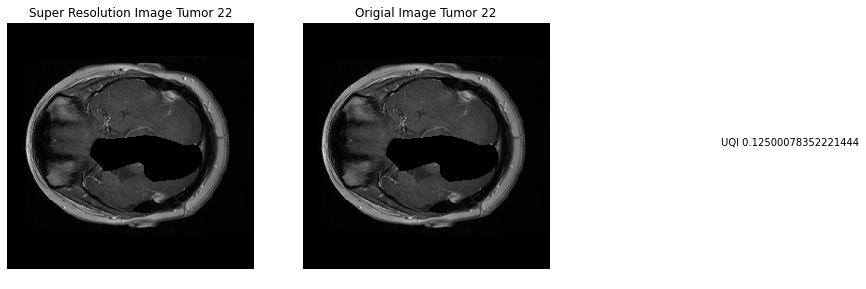

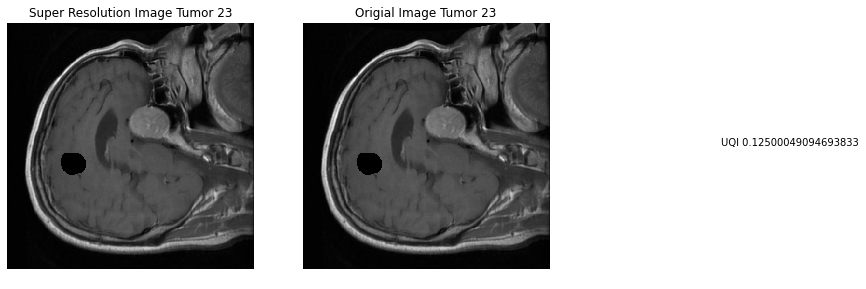

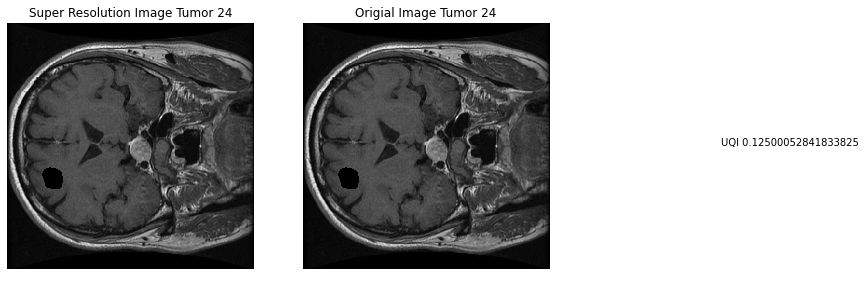

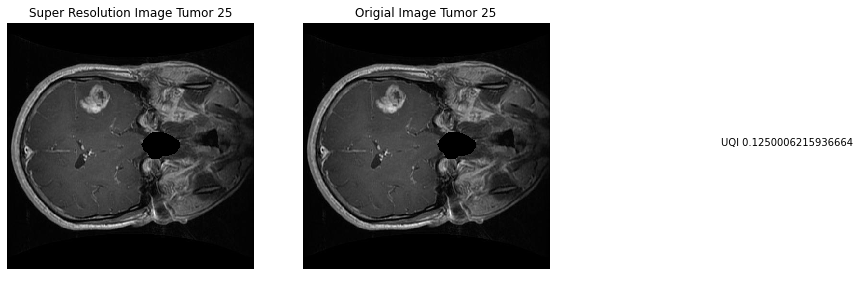

In [39]:
displayResults(sr_mask_removed, hr_mask_removed, uqi_arr, "UQI")